In [1]:
pwd()

"/home/bigcolin/Scripts/gplsim/quantile/qgplsim"

# Start

In [8]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1278


# QGPLSIM fitting

In [70]:
# run this ceil for different data sets

α = [1.0, 0.5, 0.25] # single index for x
θ = [1.0, -1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.00, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 500
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha, theta, gamma, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

 11.851554 seconds (4.00 M allocations: 12.704 GiB, 7.19% gc time)
Estimation of index coefs: 
̂α => [0.8320679675477973, 0.5247387839273362, 0.17975568425876848]
̂γ => [1.3032848027129134, 0.30521468978426675]
Estimation of linear coefs: 
̂θ => [1.0785788366238693 -1.0276951736542121 -1.9925900326065198]
̂β => [-0.18440094742382188, -1.125072611338]


In [368]:
70^(-0.2)

0.4275435825099656

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [1]:
using Plots
# include("qgplsim.ji")

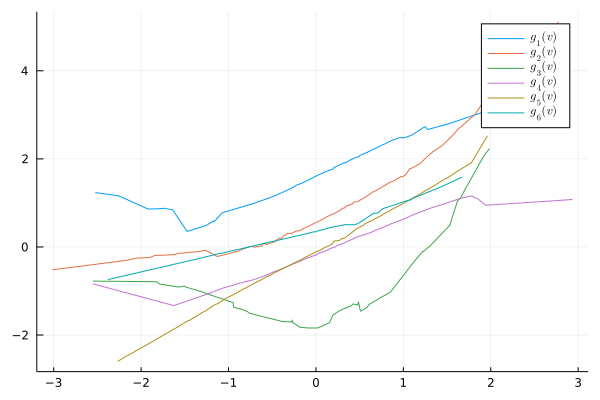

In [297]:

v = X * alpha # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y, -0.15) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

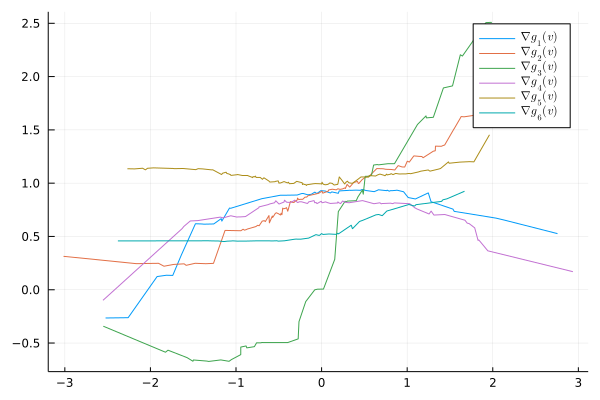

In [298]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [3]:
Threads.nthreads()

12

In [71]:
include("MonteCarloSIM.ji")

simulation (generic function with 2 methods)

In [72]:
α = [1.0, 0.5, 0.25] # single index for x
θ = [1.0, -1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.00, 0.5] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 250
fx = 2
dist = 1 # Cauchy
len = 200 # MC rept. times
alpha_type = 1

1

In [73]:
res, Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, len, alpha_type)


0.0%┣                                              ┫ 0/200 [00:00<00:-10, 0s/it]
0.5%┣▏                                         ┫ 1/200 [00:06<Inf:Inf, InfGs/it]
1.0%┣▌                                              ┫ 2/200 [00:09<28:07, 9s/it]
1.5%┣▊                                              ┫ 3/200 [00:11<17:26, 5s/it]
2.0%┣█                                              ┫ 4/200 [00:13<14:42, 4s/it]
2.5%┣█▏                                             ┫ 5/200 [00:16<12:48, 4s/it]
3.0%┣█▍                                             ┫ 6/200 [00:18<11:42, 4s/it]
3.5%┣█▋                                             ┫ 7/200 [00:20<10:56, 3s/it]
4.0%┣█▉                                             ┫ 8/200 [00:23<10:30, 3s/it]
4.5%┣██▏                                            ┫ 9/200 [00:25<10:07, 3s/it]
5.0%┣██▎                                           ┫ 10/200 [00:28<09:58, 3s/it]
5.5%┣██▌                                           ┫ 11/200 [00:30<09:35, 3s/it]
6.0%┣██▊                    

(Dict(:var_β2 => 0.616341385951152,:α1 => -0.0018057661136520636,:γ1 => 0.02195339003756106,:var_α2 => 0.2920614579419202,:γ2 => -0.015373682505315607,:θ1 => 1.0734343028102706,:var_γ2 => 0.3681586620593652,:α2 => 0.04594986607016488,:β1 => 1.2334023986579754,:var_γ1 => 1.2827015929883077…), [0.8639821430785869 -0.03119775457975988 0.502555028380488; 0.8570160429162595 0.43850049843565897 0.2706304030515315; … ; -0.8603019268491009 -0.4903473659723639 0.13942759893108894; 0.9760462382446929 0.09874494400103948 0.19386381003842743], [1.215425301699269 0.5238145342361561; 0.883252037913529 0.6502192702688708; … ; -1.094516129746273 -0.882395391693772; 0.7872797544333383 0.13812861778031188], [1.1825536663322627 -0.6912857522847787 -2.0759354802387633; 1.0899740828390574 -0.8930792686282307 -2.0046142813328878; … ; 0.47846413767310425 -1.329627768212069 -1.7238757329309686; 0.5000682796242577 -0.8542332123061221 -2.08258855739876], [1.1933515570288524 -0.3997968630230068; 0.47249519580182

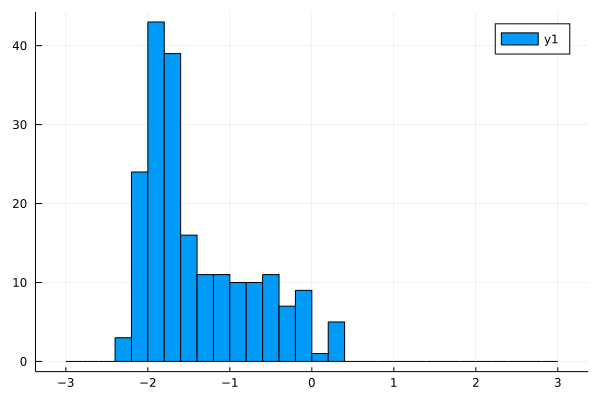

In [95]:
histogram(Theta[:,3], bins = -3:0.2:3)

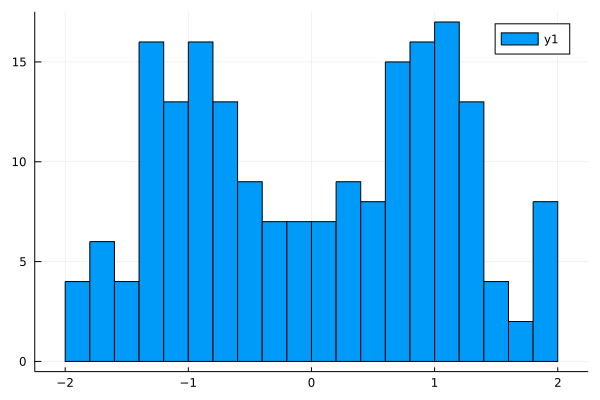

In [82]:
histogram(Gamma[:,1], bins = -2:0.2:2)

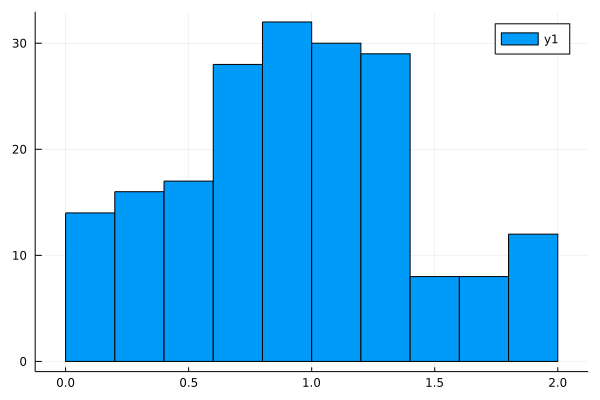

In [75]:
histogram(abs.(Gamma[:,1]), bins = 0:0.2:2)

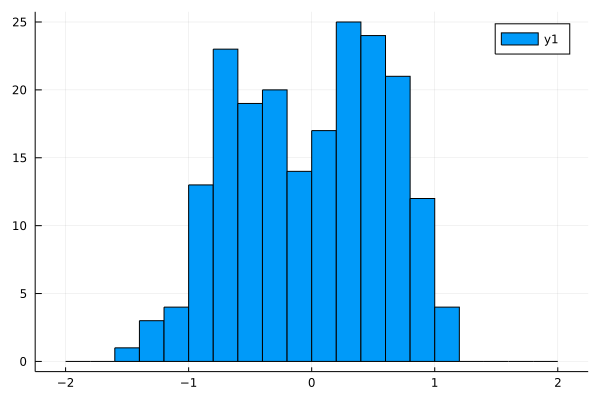

In [79]:
histogram(Gamma[:,2], bins = -2:0.2:2)

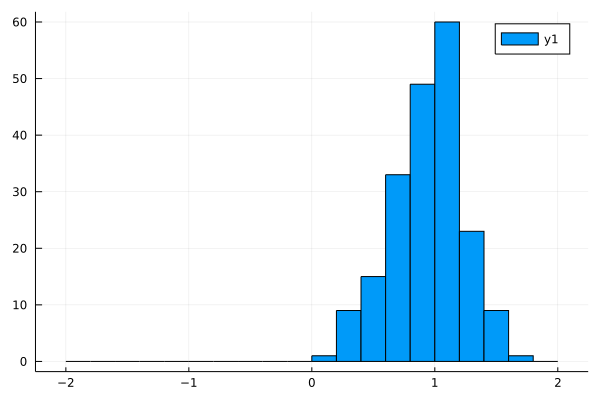

In [38]:
histogram(abs.(Gamma[:,2]), bins = -2:0.2:2)

In [86]:
Rg = kmeans(transpose(Gamma), 2)
Rg.centers

2×2 Array{Float64,2}:
 1.01251   -0.948989
 0.421648  -0.443742

In [120]:
t = randn(100) *3
var(t)

10.647726714457002

In [123]:
ind1 = Rg.assignments .== 1
ind2 = Rg.assignments .== 2
v1 = var(Gamma[ind1, :], dims = 1)

1×2 Array{Float64,2}:
 0.310815  0.165007

In [124]:
v2 = var(Gamma[ind2, :], dims = 1)

1×2 Array{Float64,2}:
 0.32443  0.196516

In [128]:
len1 = sum(ind1) - 1
len2 = sum(ind2) - 1

100

In [129]:
(v1 * len1 + v2* len2) /(len - 1)

1×2 Array{Float64,2}:
 0.316095  0.180012

In [104]:
var(abs.(Gamma), dims = 1)

1×2 Array{Float64,2}:
 0.29951  0.0891436

In [48]:
g1 = sum(Rg.assignments .== 1)
g2 = 200 - g1

107

In [50]:
(g2 * Rg.centers[:, 2] -  g1 * Rg.centers[:, 1] ) / 200

2-element Array{Float64,1}:
 0.7445073464997245
 0.9359496665289737

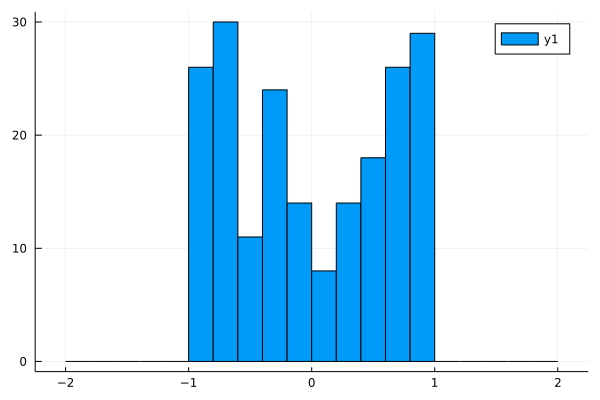

In [83]:
histogram(Alpha[:,1], bins = -2:0.2:2)

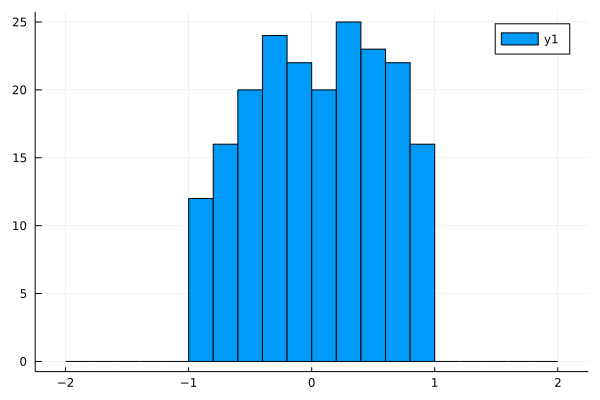

In [84]:
histogram(Alpha[:,2], bins = -2:0.2:2)

In [85]:
Ra= kmeans(transpose(Alpha), 2)
Ra.centers

3×2 Array{Float64,2}:
 -0.543466  0.529129
 -0.21783   0.304507
 -0.249278  0.204168

In [87]:
a1 = sum(Ra.assignments .== 1)
a2 = 200 - a1

101

In [88]:
(a2 * Ra.centers[:, 2] -  a1 * Ra.centers[:, 1] ) / 200

3-element Array{Float64,1}:
 0.53622578750925
 0.2616020529549162
 0.226497242879086

In [351]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


,α1,α2,var_α1,var_α2,θ1,θ2,var_θ1,var_θ2,β1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [340]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

4-element Vector{Symbol}:
 :β1
 :β2
 :var_β1
 :var_β2

In [ ]:
@threads for γ in [[1.0, 0.5], [1.0, 0.001], [0.001, 1.0], [0.5, 1.0],[0.5, 0.5], [0.0001, 0.0001]]
    res, =  MonteCarlo(n, γ, θ, α, β, fx, dist, len, alpha_type)
    push!(df, res)
end